# Understanding Vision-Language-Action Models (VLAs)

### Lab Table of Contents
1. [1_chatgpt.ipynb](https://github.com/abbykoneill/lerobot/blob/main/lab_part2/1_chatgpt.ipynb)
2. [2_CLIP.ipynb](https://github.com/abbykoneill/lerobot/blob/main/lab_part2/2_CLIP.ipynb)
3. [3_VLM_BLIP.ipynb](https://github.com/abbykoneill/lerobot/blob/main/lab_part2/3_VLM_BLIP.ipynb)
4. **[4_VLA.ipynb](https://github.com/abbykoneill/lerobot/blob/main/lab_part2/4_VLA.ipynb)**
5. [5_safety.ipynb](https://github.com/abbykoneill/lerobot/blob/main/lab_part2/5_safety.ipynb)
6. [Lab Checkoff](https://github.com/abbykoneill/lerobot/blob/main/lab_part2/checkoff.txt)

---

## What is a VLA?

A **Vision-Language-Action (VLA)** model is the bridge between perception, language understanding, and robot control.

```
┌─────────────┐     ┌─────────────┐     ┌─────────────┐
│   Camera    │     │  Instruction│     │ Robot State │
│   Image     │     │   "pick up  │     │  (joints,   │
│             │     │   the red   │     │   gripper)  │
│             │     │   block"    │     │             │
└──────┬──────┘     └──────┬──────┘     └──────┬──────┘
       │                   │                   │
       └───────────────────┼───────────────────┘
                           │
                    ┌──────▼──────┐
                    │     VLA     │
                    │    Model    │
                    └──────┬──────┘
                           │
                    ┌──────▼──────┐
                    │   Action    │
                    │  Commands   │
                    │ (move arm,  │
                    │  close grip)│
                    └─────────────┘
```

### Key Difference from VLMs

| VLM (Vision-Language Model) | VLA (Vision-Language-Action Model) |
|-----------------------------|------------------------------------|  
| Input: Image + Text | Input: Image + Text + Robot State |
| Output: **Text** | Output: **Actions** |
| Example: "This is a cat" | Example: `[0.1, -0.3, 0.5, 0.2, 0.0, 0.1, 1.0]` |

### Learning Objectives

By the end of this notebook, you will:
1. Understand the architecture of a VLA model
2. Build a simplified VLA from scratch
3. Understand how vision, language, and state are fused
4. Learn about action tokens vs. continuous actions
5. Experiment with different model configurations


First, let's install the required dependencies and import our educational VLA module.


In [ ]:

%pip install torch numpy matplotlib --quiet


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Import our VLA module
from VLA_exercises import (
    SimpleVLA, 
    VisionEncoder, 
    LanguageEncoder, 
    StateEncoder,
    MultimodalFusion,
    ActionDecoder,
    SimpleTokenizer,
    create_demo_inputs,
    run_demo
)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✓ All modules loaded successfully!")


✓ All modules loaded successfully!


### Let's run a quick demo to see what a VLA does


In [3]:
# Run the demo from our module
model, output = run_demo()


SIMPLE VLA DEMONSTRATION

Input Shapes:
  Image: torch.Size([1, 3, 224, 224])
  Language tokens: torch.Size([1, 32])
  Robot state: torch.Size([1, 7])

Instruction: "pick up the red block"

Output Shapes:
  Vision embedding: torch.Size([1, 256])
  Language embedding: torch.Size([1, 256])
  State embedding: torch.Size([1, 256])
  Fused embedding: torch.Size([1, 512])
  Actions: torch.Size([1, 7])
  Action tokens: torch.Size([1, 7])

Predicted Actions:
  joint_1: -0.0431
  joint_2: -0.8667
  joint_3: 0.7412
  joint_4: -0.6863
  joint_5: -0.4196
  joint_6: 0.7725
  gripper: -0.9137

Demo complete! See the exercises in the notebook.


---
## Part 2: Understanding Each Component

A VLA has three main input encoders. Let's examine each one.

### 2.1 Vision Encoder

The vision encoder converts camera images into a feature vector that captures the visual scene.

**Real VLAs use:** ViT (Vision Transformer), SigLIP, CLIP visual encoder  
**Our educational version uses:** A simple CNN


In [ ]:
vision_encoder = VisionEncoder(input_channels=3, embedding_dim=256)

sample_image = torch.randn(1, 3, 224, 224)

print(f"Input image shape: {sample_image.shape}")
print(f"  - Batch size: {sample_image.shape[0]}")
print(f"  - Channels (RGB): {sample_image.shape[1]}")
print(f"  - Height: {sample_image.shape[2]}")
print(f"  - Width: {sample_image.shape[3]}")

# Encode the image
vision_embedding = vision_encoder(sample_image)

print(f"\nOutput embedding shape: {vision_embedding.shape}")
print(f"  - The 224x224x3 image is now a 256-dimensional vector!")


Input image shape: torch.Size([1, 3, 224, 224])
  - Batch size: 1
  - Channels (RGB): 3
  - Height: 224
  - Width: 224

Output embedding shape: torch.Size([1, 256])
  - The 224x224x3 image is now a 256-dimensional vector!


### 🔍 Exercise 1: Trace the Dimensions

Add print statements to understand how the image dimensions change through the CNN layers.

**Question:** Why does the image get smaller as it passes through convolutional layers?


In [11]:
# EXERCISE 1: Trace dimensions through the vision encoder

class VisionEncoderDebug(nn.Module):
    """Vision encoder with debug print statements."""
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(128 * 4 * 4, 256)
    
    def forward(self, image):
        print(f"Input: {image.shape}")
        
        x = torch.relu(self.conv1(image))
        print(f"After conv1 (8x8 kernel, stride 4): {x.shape}")
        
        # TODO: Fill in the correct shape after conv2
        x = torch.relu(self.conv2(x))
        print(f"After conv2: {x.shape}")
        
        x = torch.relu(self.conv3(x))
        print(f"After conv3: {x.shape}")
        
        x = self.pool(x)
        print(f"After pooling: {x.shape}")
        
        x = x.view(x.size(0), -1)
        print(f"After flatten: {x.shape}")
        
        x = self.fc(x)
        print(f"Final embedding: {x.shape}")
        
        return x

# Test your debug encoder
debug_encoder = VisionEncoderDebug()
_ = debug_encoder(sample_image)


Input: torch.Size([1, 3, 224, 224])
After conv1 (8x8 kernel, stride 4): torch.Size([1, 32, 56, 56])
After conv2: torch.Size([1, 64, 28, 28])
After conv3: torch.Size([1, 128, 14, 14])
After pooling: torch.Size([1, 128, 4, 4])
After flatten: torch.Size([1, 2048])
Final embedding: torch.Size([1, 256])


### 2.2 Language Encoder

The language encoder converts text instructions into a feature vector.

**Real VLAs use:** Pretrained LLMs (Llama, SmolLM), CLIP text encoder  
**Our educational version uses:** Word embeddings + LSTM


In [12]:
# Create a tokenizer and language encoder
tokenizer = SimpleTokenizer(vocab_size=1000)
language_encoder = LanguageEncoder(vocab_size=1000, embedding_dim=256)

# Sample instructions
instructions = [
    "pick up the red block",
    "move the cup to the left",
    "push the button"
]

print("Tokenizing instructions:\n")
for instruction in instructions:
    tokens = tokenizer.encode(instruction)
    print(f"'{instruction}'")
    print(f"  → Tokens: {tokens[:10].tolist()}... (padded to 32)")
    print()


Tokenizing instructions:

'pick up the red block'
  → Tokens: [2, 3, 4, 5, 6, 0, 0, 0, 0, 0]... (padded to 32)

'move the cup to the left'
  → Tokens: [7, 4, 8, 9, 4, 10, 0, 0, 0, 0]... (padded to 32)

'push the button'
  → Tokens: [11, 4, 12, 0, 0, 0, 0, 0, 0, 0]... (padded to 32)



In [13]:
# Encode the first instruction
instruction = "pick up the red block"
tokens = tokenizer.encode(instruction).unsqueeze(0)  # Add batch dimension

print(f"Token shape: {tokens.shape}")

language_embedding = language_encoder(tokens)

print(f"Language embedding shape: {language_embedding.shape}")
print(f"  - The instruction is now a 256-dimensional vector!")


Token shape: torch.Size([1, 32])
Language embedding shape: torch.Size([1, 256])
  - The instruction is now a 256-dimensional vector!


### 2.3 State Encoder

The state encoder processes the robot's current configuration (joint positions, gripper state, etc.).

For a typical 6-DOF robot arm:
- 6 joint angles (shoulder, elbow, wrist, etc.)
- 1 gripper state (open/closed)


In [14]:
# Create a state encoder
state_encoder = StateEncoder(state_dim=7, embedding_dim=256)

# Sample robot state: [joint1, joint2, joint3, joint4, joint5, joint6, gripper]
robot_state = torch.tensor([[
    0.5,   # Joint 1 angle (normalized)
    -0.3,  # Joint 2 angle
    0.8,   # Joint 3 angle
    0.0,   # Joint 4 angle
    0.2,   # Joint 5 angle
    -0.1,  # Joint 6 angle
    1.0    # Gripper (1.0 = closed, -1.0 = open)
]])

print(f"Robot state: {robot_state.tolist()[0]}")
print(f"State shape: {robot_state.shape}")

state_embedding = state_encoder(robot_state)

print(f"\nState embedding shape: {state_embedding.shape}")
print(f"  - The 7 joint values are now a 256-dimensional vector!")


Robot state: [0.5, -0.30000001192092896, 0.800000011920929, 0.0, 0.20000000298023224, -0.10000000149011612, 1.0]
State shape: torch.Size([1, 7])

State embedding shape: torch.Size([1, 256])
  - The 7 joint values are now a 256-dimensional vector!


---
## Part 3: Multimodal Fusion

**The key insight of VLAs:** How do we combine vision, language, and state into a unified representation?

This is one of the most important design decisions in VLA architecture.


In [15]:
# We have three embeddings of the same dimension
print("Input embeddings:")
print(f"  Vision:   {vision_embedding.shape}")
print(f"  Language: {language_embedding.shape}")
print(f"  State:    {state_embedding.shape}")

# Create fusion modules with different strategies
fusion_concat = MultimodalFusion(embedding_dim=256, fusion_dim=512, fusion_type="concat")
fusion_attention = MultimodalFusion(embedding_dim=256, fusion_dim=512, fusion_type="attention")

# Try concatenation fusion
fused_concat = fusion_concat(vision_embedding, language_embedding, state_embedding)
print(f"\nConcatenation fusion output: {fused_concat.shape}")

# Try attention fusion
fused_attention = fusion_attention(vision_embedding, language_embedding, state_embedding)
print(f"Attention fusion output: {fused_attention.shape}")


Input embeddings:
  Vision:   torch.Size([1, 256])
  Language: torch.Size([1, 256])
  State:    torch.Size([1, 256])

Concatenation fusion output: torch.Size([1, 512])
Attention fusion output: torch.Size([1, 512])


### 🔍 Exercise 2: Implement Multiplicative Fusion

**Your task:** Implement a new fusion strategy that multiplies embeddings element-wise.

| Fusion Type | Pros | Cons |
|-------------|------|------|
| Concatenation | Simple, fast | Doesn't capture interactions |
| Attention | Learns modality importance | More complex |
| Multiplicative | Forces shared representations | ??? (you figure out!) |


In [16]:
# EXERCISE 2: Implement multiplicative fusion

class MultiplicativeFusion(nn.Module):
    """Fuses embeddings by element-wise multiplication."""
    
    def __init__(self, embedding_dim=256, fusion_dim=512):
        super().__init__()
        # TODO: Define the layers needed
        # Hint: After multiplying, you need to project to fusion_dim
        self.projection = nn.Linear(embedding_dim, fusion_dim)  # Fix this if needed
    
    def forward(self, vision_emb, language_emb, state_emb):
        # TODO: Implement multiplicative fusion
        # Step 1: Multiply all three embeddings element-wise
        # Step 2: Project to fusion_dim
        
        # Your code here:
        # fused = ???
        # return self.projection(fused)
        pass

# Test your implementation (uncomment when ready)
# mult_fusion = MultiplicativeFusion()
# fused_mult = mult_fusion(vision_embedding, language_embedding, state_embedding)
# print(f"Multiplicative fusion output: {fused_mult.shape}")


---
## Part 4: Action Decoding

The final stage: converting the fused representation into robot actions.

### Two Approaches:

1. **Continuous Actions** (Traditional robotics)
   - Output: `[-0.3, 0.5, 0.1, ...]` (float values)
   - Pro: Precise control
   - Con: Hard to use language model techniques

2. **Action Tokens** (Modern VLAs like RT-2)
   - Output: `[127, 192, 64, ...]` (discrete bins)
   - Pro: Can use autoregressive generation like LLMs
   - Con: Quantization loses some precision


In [17]:
# Create action decoders with both approaches
decoder_continuous = ActionDecoder(fusion_dim=512, action_dim=7, use_action_tokens=False)
decoder_tokens = ActionDecoder(fusion_dim=512, action_dim=7, num_action_bins=256, use_action_tokens=True)

print("Fused input shape:", fused_attention.shape)
print()

# Continuous actions
output_continuous = decoder_continuous(fused_attention)
print("=== Continuous Action Output ===")
print(f"Actions shape: {output_continuous['actions'].shape}")
print(f"Actions: {output_continuous['actions'][0].detach().numpy().round(3)}")
print()

# Tokenized actions
output_tokens = decoder_tokens(fused_attention)
print("=== Tokenized Action Output ===")
print(f"Action tokens: {output_tokens['action_tokens'][0].tolist()}")
print(f"Converted to continuous: {output_tokens['actions'][0].detach().numpy().round(3)}")


Fused input shape: torch.Size([1, 512])

=== Continuous Action Output ===
Actions shape: torch.Size([1, 7])
Actions: [-0.07  -0.029 -0.052 -0.039  0.072 -0.023 -0.045]

=== Tokenized Action Output ===
Action tokens: [89, 189, 226, 202, 141, 154, 130]
Converted to continuous: [-0.302  0.482  0.773  0.584  0.106  0.208  0.02 ]


### 🔍 Exercise 3: Calculate Action Token Precision

**Question:** If we discretize actions into 256 bins:
- What is the precision (step size) between bins?
- Is this precise enough for delicate robot manipulation?


In [18]:
# EXERCISE 3: Calculate action precision

num_bins = 256
action_range = 2.0  # Actions range from -1 to 1

# TODO: Calculate the precision (step size between bins)
# Formula: action_range / (num_bins - 1)
precision_256 = action_range / (num_bins - 1)

print(f"With {num_bins} bins:")
print(f"  Action range: [-1, 1] = {action_range}")
print(f"  Precision: {precision_256:.6f}")

# TODO: What if we only had 16 bins?
num_bins_16 = 16
precision_16 = action_range / (num_bins_16 - 1)
print(f"\nWith only {num_bins_16} bins:")
print(f"  Precision: {precision_16:.6f}")

# Reflection: A typical servo motor has ~0.1 degree precision
# Is 256 bins enough?


With 256 bins:
  Action range: [-1, 1] = 2.0
  Precision: 0.007843

With only 16 bins:
  Precision: 0.133333


---
## Part 5: The Complete VLA Pipeline

Now let's use the complete SimpleVLA model and see the full pipeline in action.


In [19]:
# Create the complete VLA model
vla = SimpleVLA(
    image_channels=3,
    vocab_size=1000,
    state_dim=7,
    action_dim=7,
    embedding_dim=256,
    fusion_dim=512,
    num_action_bins=256,
    fusion_type="attention",
    use_action_tokens=True
)

vla.eval()
print(f"Model created with {sum(p.numel() for p in vla.parameters()):,} parameters")


Model created with 3,761,248 parameters


In [20]:
# Create inputs
image = torch.randn(1, 3, 224, 224)  # Random image
instruction = "pick up the red block"
tokens = tokenizer.encode(instruction).unsqueeze(0)
state = torch.tensor([[0.5, -0.3, 0.8, 0.0, 0.2, -0.1, 1.0]])

print("Inputs:")
print(f"  Image: {image.shape}")
print(f"  Instruction: '{instruction}'")
print(f"  Robot state: {state[0].tolist()}")

# Forward pass
with torch.no_grad():
    output = vla(image, tokens, state)

print("\n" + "="*50)
print("OUTPUT ACTIONS")
print("="*50)

actions = output['actions'][0].numpy()
action_names = ["joint_1", "joint_2", "joint_3", "joint_4", "joint_5", "joint_6", "gripper"]

for name, value in zip(action_names, actions):
    bar_len = int((value + 1) * 20)
    bar = "█" * max(0, bar_len)
    print(f"  {name:10s}: {value:+.3f} |{bar}")


Inputs:
  Image: torch.Size([1, 3, 224, 224])
  Instruction: 'pick up the red block'
  Robot state: [0.5, -0.30000001192092896, 0.800000011920929, 0.0, 0.20000000298023224, -0.10000000149011612, 1.0]

OUTPUT ACTIONS
  joint_1   : -0.271 |██████████████
  joint_2   : -0.498 |██████████
  joint_3   : +0.380 |███████████████████████████
  joint_4   : -0.137 |█████████████████
  joint_5   : +0.090 |█████████████████████
  joint_6   : +0.294 |█████████████████████████
  gripper   : -0.914 |█


### 🔍 Exercise 4: Test Instruction Sensitivity

Does the (untrained) model respond differently to different instructions?

**Key insight:** An *untrained* model produces random outputs. Only through training does it learn meaningful mappings!


In [21]:
# EXERCISE 4: Test different instructions

test_instructions = [
    "pick up the red block",
    "pick up the blue block", 
    "put down the object",
    "move left",
    "wave hello"
]

print("Testing instruction sensitivity:\n")
print("Note: This is an UNTRAINED model!")
print("="*60)

results = []

for test_instruction in test_instructions:
    test_tokens = tokenizer.encode(test_instruction).unsqueeze(0)
    
    with torch.no_grad():
        test_output = vla(image, test_tokens, state)
    
    test_actions = test_output['actions'][0].numpy()
    results.append(test_actions)
    
    print(f"\n'{test_instruction}'")
    print(f"  Actions: {test_actions.round(2)}")

print("\n" + "="*60)
print("Similarity analysis (lower = more similar):")
for i in range(len(test_instructions)):
    for j in range(i+1, len(test_instructions)):
        diff = np.abs(results[i] - results[j]).mean()
        print(f"  '{test_instructions[i][:15]}' vs '{test_instructions[j][:15]}': {diff:.3f}")


Testing instruction sensitivity:

Note: This is an UNTRAINED model!

'pick up the red block'
  Actions: [-0.27 -0.5   0.38 -0.14  0.09  0.29 -0.91]

'pick up the blue block'
  Actions: [-0.27 -0.5   0.38 -0.14  0.09  0.29 -0.91]

'put down the object'
  Actions: [ 0.67 -0.5   0.38 -0.14  0.09  0.29 -0.91]

'move left'
  Actions: [-0.27 -0.5   0.38 -0.14  0.09  0.29 -0.91]

'wave hello'
  Actions: [ 0.67 -0.5   0.38 -0.14  0.09  0.29  0.07]

Similarity analysis (lower = more similar):
  'pick up the red' vs 'pick up the blu': 0.000
  'pick up the red' vs 'put down the ob': 0.134
  'pick up the red' vs 'move left': 0.000
  'pick up the red' vs 'wave hello': 0.275
  'pick up the blu' vs 'put down the ob': 0.134
  'pick up the blu' vs 'move left': 0.000
  'pick up the blu' vs 'wave hello': 0.275
  'put down the ob' vs 'move left': 0.134
  'put down the ob' vs 'wave hello': 0.140
  'move left' vs 'wave hello': 0.275


---
## Part 6: Visualizing the VLA Pipeline


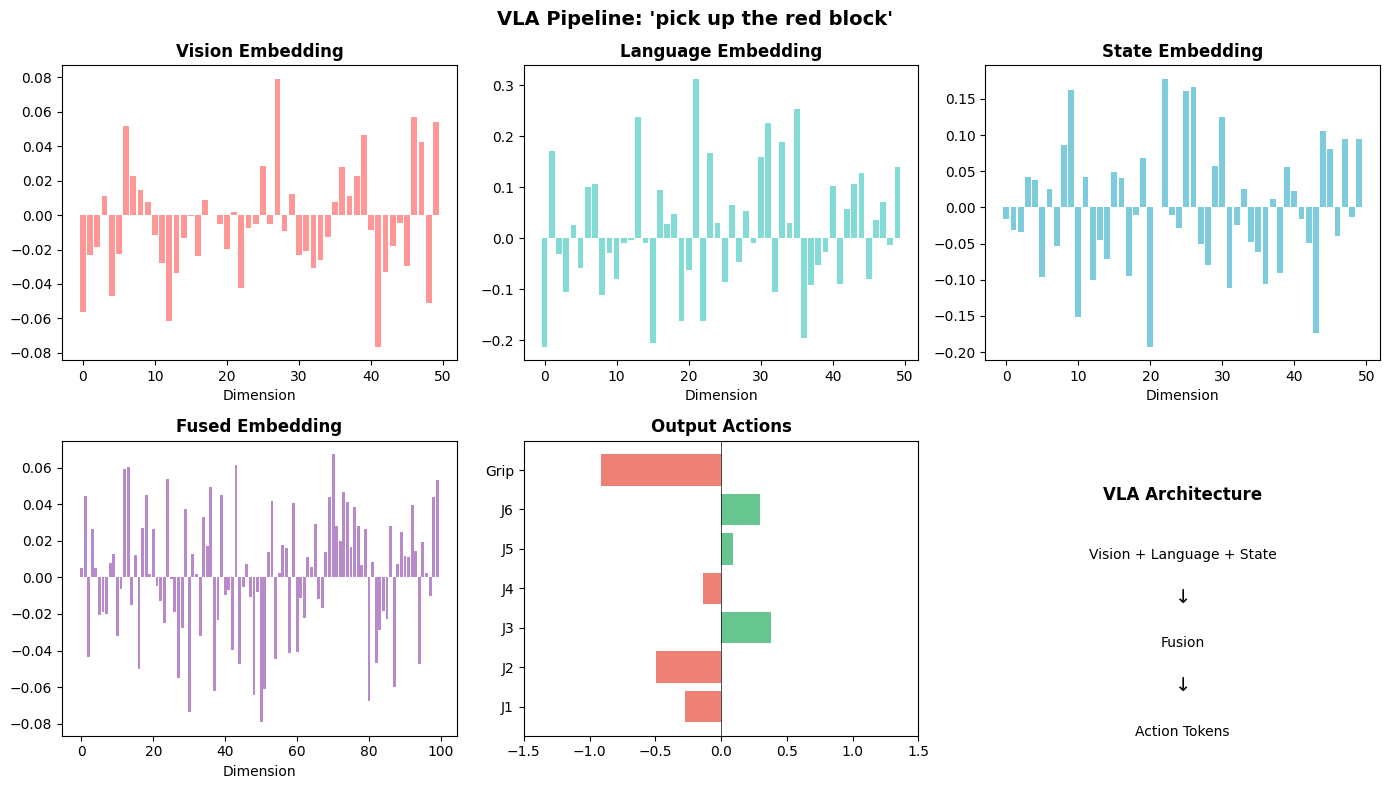

In [22]:
def visualize_vla_pipeline(model, img, toks, st, instr):
    """Visualize the VLA pipeline with embeddings and outputs."""
    with torch.no_grad():
        out = model(img, toks, st)
    
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    fig.suptitle(f"VLA Pipeline: '{instr}'", fontsize=14, fontweight='bold')
    
    # Vision embedding
    ax = axes[0, 0]
    vision_emb = out['vision_embedding'][0].numpy()
    ax.bar(range(50), vision_emb[:50], color='#FF6B6B', alpha=0.7)
    ax.set_title('Vision Embedding', fontweight='bold')
    ax.set_xlabel('Dimension')
    
    # Language embedding  
    ax = axes[0, 1]
    lang_emb = out['language_embedding'][0].numpy()
    ax.bar(range(50), lang_emb[:50], color='#4ECDC4', alpha=0.7)
    ax.set_title('Language Embedding', fontweight='bold')
    ax.set_xlabel('Dimension')
    
    # State embedding
    ax = axes[0, 2]
    state_emb = out['state_embedding'][0].numpy()
    ax.bar(range(50), state_emb[:50], color='#45B7D1', alpha=0.7)
    ax.set_title('State Embedding', fontweight='bold')
    ax.set_xlabel('Dimension')
    
    # Fused embedding
    ax = axes[1, 0]
    fused_emb = out['fused_embedding'][0].numpy()
    ax.bar(range(100), fused_emb[:100], color='#9B59B6', alpha=0.7)
    ax.set_title('Fused Embedding', fontweight='bold')
    ax.set_xlabel('Dimension')
    
    # Actions
    ax = axes[1, 1]
    act = out['actions'][0].numpy()
    names = ['J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'Grip']
    colors = ['#E74C3C' if a < 0 else '#27AE60' for a in act]
    ax.barh(names, act, color=colors, alpha=0.7)
    ax.set_title('Output Actions', fontweight='bold')
    ax.set_xlim(-1.5, 1.5)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Architecture diagram
    ax = axes[1, 2]
    ax.text(0.5, 0.8, 'VLA Architecture', ha='center', fontsize=12, fontweight='bold')
    ax.text(0.5, 0.6, 'Vision + Language + State', ha='center', fontsize=10)
    ax.text(0.5, 0.45, '↓', ha='center', fontsize=14)
    ax.text(0.5, 0.3, 'Fusion', ha='center', fontsize=10)
    ax.text(0.5, 0.15, '↓', ha='center', fontsize=14)
    ax.text(0.5, 0.0, 'Action Tokens', ha='center', fontsize=10)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_vla_pipeline(vla, image, tokens, state, instruction)


---
## Part 7: Reflection Questions

Before moving on, reflect on these questions:

1. **Architecture Design:** Why do we convert all modalities to the same embedding dimension before fusion?

2. **Training Data:** What kind of data would you need to train a VLA? How is this different from training a VLM?



In [ ]:
# YOUR REFLECTIONS (write your answers here!)

# Q1: Why same embedding dimension?
# Answer: 

# Q2: Why action tokens?
# Answer:

# Q3: Training data challenges?
# Answer:

# Q4: Safety considerations?
# Answer:


---
## Part 8: Challenge Exercises (Optional)

### Challenge 1: Temporal Vision

Real robots need to consider history. Modify the vision encoder to process a sequence of frames.


In [ ]:
# CHALLENGE 1: Temporal Vision Encoder

class TemporalVisionEncoder(nn.Module):
    """
    Input: (batch, num_frames, channels, height, width)
    Output: (batch, embedding_dim)
    """
    def __init__(self, embedding_dim=256, num_frames=4):
        super().__init__()
        # TODO: Implement
        # Hint: Process each frame with CNN, then use LSTM across time
        pass
    
    def forward(self, image_sequence):
        # TODO: Implement
        pass

# Test (uncomment when ready)
# temporal_encoder = TemporalVisionEncoder()
# image_seq = torch.randn(1, 4, 3, 224, 224)
# temporal_emb = temporal_encoder(image_seq)
# print(f"Temporal embedding: {temporal_emb.shape}")


### Challenge 2: Action Chunking

Instead of predicting one action, predict a sequence of K future actions.


In [ ]:
# CHALLENGE 2: Action Chunking

class ChunkedActionDecoder(nn.Module):
    """
    Input: (batch, fusion_dim)
    Output: (batch, chunk_size, action_dim)
    """
    def __init__(self, fusion_dim=512, action_dim=7, chunk_size=10):
        super().__init__()
        self.chunk_size = chunk_size
        self.action_dim = action_dim
        # TODO: Implement
        pass
    
    def forward(self, fused):
        # TODO: Implement
        pass

# Test (uncomment when ready)
# chunked = ChunkedActionDecoder(chunk_size=10)
# action_chunk = chunked(fused_attention)
# print(f"Action chunk: {action_chunk.shape}")  # Should be (1, 10, 7)


---
## Summary

### What You've Learned

1. **VLA Architecture:** Vision + Language + State → Action
2. **Modality Encoding:** Converting different inputs into embeddings
3. **Multimodal Fusion:** Combining information from different modalities
4. **Action Representation:** Continuous vs. discrete action tokens

### Real-World VLAs

| Model | Vision | Language | Key Innovation |
|-------|--------|----------|----------------|
| RT-2 | ViT-L | PaLI-X | Action tokens as language |
| OpenVLA | SigLIP | Llama 2 | Open-source |
| SmolVLA | SigLIP | SmolLM | Lightweight |

---

## Continue to: [5_safety.ipynb](https://github.com/abbykoneill/lerobot/blob/main/lab_part2/5_safety.ipynb)

---

## References

* [RT-2: Vision-Language-Action Models](https://robotics-transformer2.github.io/)
* [OpenVLA](https://openvla.github.io/)
* [SmolVLA](https://huggingface.co/blog/smolvla)
* [LeRobot](https://github.com/huggingface/lerobot)
